<a href="https://colab.research.google.com/github/TAUforPython/fuzzy/blob/main/example%20Fuzzy%20Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

additional info:
https://zenodo.org/records/3841923

In [1]:
# Fuzzy Neural Network vs MLP Comparison with Advanced Metrics
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import time
import seaborn as sns

In [20]:
# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

class FuzzyLayer(nn.Module):
    """
    Fuzzy Layer implementation using Gaussian membership functions
    """
    def __init__(self, input_dim, num_memberships):
        super(FuzzyLayer, self).__init__()
        self.input_dim = input_dim
        self.num_memberships = num_memberships

        # Initialize centers and sigmas for Gaussian membership functions
        self.centers = nn.Parameter(torch.randn(num_memberships, input_dim))
        self.sigmas = nn.Parameter(torch.ones(num_memberships, input_dim))

    def forward(self, x):
        # x shape: (batch_size, input_dim)
        # centers shape: (num_memberships, input_dim)
        # sigmas shape: (num_memberships, input_dim)

        # Expand dimensions for broadcasting
        x_expanded = x.unsqueeze(1)  # (batch_size, 1, input_dim)
        centers_expanded = self.centers.unsqueeze(0)  # (1, num_memberships, input_dim)
        sigmas_expanded = self.sigmas.unsqueeze(0)  # (1, num_memberships, input_dim)

        # Calculate Gaussian membership function
        # μ(x) = exp(-0.5 * ((x - center) / sigma)^2)
        diff = x_expanded - centers_expanded
        normalized_diff = diff / sigmas_expanded
        membership_values = torch.exp(-0.5 * normalized_diff ** 2)

        # Combine memberships across features (product t-norm)
        fuzzy_output = torch.prod(membership_values, dim=2)  # (batch_size, num_memberships)

        return fuzzy_output

class FuzzyNeuralNetwork(nn.Module):
    """
    Complete Fuzzy Neural Network
    """
    def __init__(self, input_dim, num_fuzzy_memberships, hidden_dim, output_dim):
        super(FuzzyNeuralNetwork, self).__init__()

        # Fuzzy layer
        self.fuzzy_layer = FuzzyLayer(input_dim, num_fuzzy_memberships)

        # Neural network layers
        self.hidden_layer = nn.Linear(num_fuzzy_memberships, hidden_dim)
        self.output_layer = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Fuzzy layer
        fuzzy_output = self.fuzzy_layer(x)

        # Neural network layers
        hidden_output = self.relu(self.hidden_layer(fuzzy_output))
        output = self.sigmoid(self.output_layer(hidden_output))

        return output

class MLPNetwork(nn.Module):
    """
    Simple Multi-Layer Perceptron for comparison
    """
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim):
        super(MLPNetwork, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, output_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)

def generate_sample_data(n_samples=1000, n_features=4, n_classes=2, dataset_type='balanced'):
    """
    Generate sample data for demonstration
    """
    if dataset_type == 'balanced':
        X, y = make_classification(
            n_samples=n_samples,
            n_features=n_features,
            n_classes=n_classes,
            n_redundant=0,
            n_informative=n_features,
            random_state=42,
            n_clusters_per_class=1,
            class_sep=1.0
        )
    elif dataset_type == 'imbalanced':
        X, y = make_classification(
            n_samples=n_samples,
            n_features=n_features,
            n_classes=n_classes,
            n_redundant=1,
            n_informative=n_features-1,
            random_state=42,
            class_sep = 1.5,
            n_clusters_per_class=2,
            flip_y=0.1,
            weights=[0.7, 0.3]  # Imbalanced classes
        )
    else:  # Complex dataset
        X, y = make_classification(
            n_samples=n_samples,
            n_features=n_features,
            n_classes=n_classes,
            n_redundant=2,
            n_informative=n_features-2,
            random_state=42,
            n_clusters_per_class=2,
            flip_y=0.15,
            class_sep=0.7
        )

    return X, y

def train_model(model, train_loader, val_loader, num_epochs=100, learning_rate=0.01, model_name="Model"):
    """
    Train the model and return training history
    """
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    print(f"\nTraining {model_name}...")
    start_time = time.time()

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs.squeeze(), batch_y.float())
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            predicted = (outputs.squeeze() > 0.5).float()
            train_total += batch_y.size(0)
            train_correct += (predicted == batch_y.float()).sum().item()

        avg_train_loss = train_loss / len(train_loader)
        train_accuracy = 100 * train_correct / train_total

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                outputs = model(batch_x)
                loss = criterion(outputs.squeeze(), batch_y.float())
                val_loss += loss.item()
                predicted = (outputs.squeeze() > 0.5).float()
                val_total += batch_y.size(0)
                val_correct += (predicted == batch_y.float()).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * val_correct / val_total

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        if epoch % 20 == 0:
            print(f'Epoch [{epoch}/{num_epochs}], '
                  f'Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, '
                  f'Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')

    end_time = time.time()
    training_time = end_time - start_time

    print(f"{model_name} training completed in {training_time:.2f} seconds")

    return train_losses, val_losses, train_accuracies, val_accuracies, training_time

def get_predictions(model, data_loader):
    """
    Get predictions from model
    """
    model.eval()
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for batch_x, batch_y in data_loader:
            outputs = model(batch_x)
            predicted = (outputs.squeeze() > 0.5).float()
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(batch_y.cpu().numpy())

    return np.array(all_targets), np.array(all_predictions)

def calculate_metrics(y_true, y_pred):
    """
    Calculate precision, recall, and other metrics
    """
    # Calculate confusion matrix components
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Calculate metrics
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    accuracy = (tp + tn) / (tp + tn + fp + fn)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'specificity': specificity,
        'f1_score': f1_score,
        'tp': tp,
        'tn': tn,
        'fp': fp,
        'fn': fn
    }

def plot_confusion_matrix(y_true, y_pred, model_name, ax):
    """
    Plot confusion matrix
    """
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f'{model_name}\nConfusion Matrix')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

def plot_detailed_metrics(results_dict):
    """
    Plot detailed metrics comparison
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.ravel()

    # Metrics to plot
    metrics = ['accuracy', 'precision', 'recall', 'specificity', 'f1_score']
    metric_names = ['Accuracy', 'Precision', 'Recall', 'Specificity', 'F1-Score']

    # Plot each metric
    for i, (metric, metric_name) in enumerate(zip(metrics, metric_names)):
        model_names = list(results_dict.keys())
        values = [results_dict[name][metric] * 100 for name in model_names]  # Convert to percentage

        bars = axes[i].bar(model_names, values, color=['skyblue', 'lightcoral'])
        axes[i].set_ylabel('Percentage (%)')
        axes[i].set_title(f'{metric_name} Comparison')
        axes[i].set_ylim(0, 100)

        # Add value labels on bars
        for bar, value in zip(bars, values):
            axes[i].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                        f'{value:.1f}%', ha='center', va='bottom')

    # Plot training times
    model_names = list(results_dict.keys())
    training_times = [results_dict[name]['training_time'] for name in model_names]

    bars = axes[5].bar(model_names, training_times, color=['lightgreen', 'orange'])
    axes[5].set_ylabel('Training Time (seconds)')
    axes[5].set_title('Training Time Comparison')

    # Add value labels on bars
    for bar, time_val in zip(bars, training_times):
        axes[5].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                    f'{time_val:.1f}s', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

def plot_confusion_matrices(results_dict):
    """
    Plot confusion matrices for both models
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    for i, (model_name, metrics) in enumerate(results_dict.items()):
        cm = np.array([[metrics['tn'], metrics['fp']],
                       [metrics['fn'], metrics['tp']]])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
        axes[i].set_title(f'{model_name}\nConfusion Matrix')
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('Actual')
        axes[i].set_xticklabels(['Negative', 'Positive'])
        axes[i].set_yticklabels(['Negative', 'Positive'])

    plt.tight_layout()
    plt.show()

def plot_training_curves(results_dict):
    """
    Plot training curves comparison
    """
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

    # Plot training losses
    for model_name, metrics in results_dict.items():
        if 'train_losses' in metrics:
            ax1.plot(metrics['train_losses'], label=f'{model_name} Train')
            ax1.plot(metrics['val_losses'], label=f'{model_name} Val', linestyle='--')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss Comparison')
    ax1.legend()
    ax1.grid(True)

    # Plot training accuracies
    for model_name, metrics in results_dict.items():
        if 'train_accuracies' in metrics:
            ax2.plot(metrics['train_accuracies'], label=f'{model_name} Train')
            ax2.plot(metrics['val_accuracies'], label=f'{model_name} Val', linestyle='--')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Training and Validation Accuracy Comparison')
    ax2.legend()
    ax2.grid(True)

    # Plot precision comparison
    model_names = list(results_dict.keys())
    precisions = [results_dict[name]['precision'] * 100 for name in model_names]
    recalls = [results_dict[name]['recall'] * 100 for name in model_names]

    x = np.arange(len(model_names))
    width = 0.35

    ax3.bar(x - width/2, precisions, width, label='Precision', color='skyblue')
    ax3.bar(x + width/2, recalls, width, label='Recall', color='lightcoral')

    ax3.set_xlabel('Models')
    ax3.set_ylabel('Percentage (%)')
    ax3.set_title('Precision and Recall Comparison')
    ax3.set_xticks(x)
    ax3.set_xticklabels(model_names)
    ax3.legend()
    ax3.set_ylim(0, 100)

    # Add value labels
    for i, (prec, rec) in enumerate(zip(precisions, recalls)):
        ax3.text(i - width/2, prec + 1, f'{prec:.1f}%', ha='center', va='bottom')
        ax3.text(i + width/2, rec + 1, f'{rec:.1f}%', ha='center', va='bottom')

    # Plot F1 scores
    f1_scores = [results_dict[name]['f1_score'] * 100 for name in model_names]
    bars = ax4.bar(model_names, f1_scores, color=['lightgreen', 'orange'])
    ax4.set_ylabel('F1-Score (%)')
    ax4.set_title('F1-Score Comparison')
    ax4.set_ylim(0, 100)

    # Add value labels
    for bar, f1 in zip(bars, f1_scores):
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                f'{f1:.1f}%', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

def print_detailed_comparison(results_dict):
    """
    Print detailed comparison results with all metrics
    """
    print("\n" + "="*80)
    print("DETAILED MODEL COMPARISON RESULTS")
    print("="*80)

    print(f"{'Model':<15} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} "
          f"{'Train Time':<12} {'Parameters':<12}")
    print("-"*80)

    for model_name, metrics in results_dict.items():
        accuracy = metrics['accuracy'] * 100
        precision = metrics['precision'] * 100
        recall = metrics['recall'] * 100
        f1_score = metrics['f1_score'] * 100
        train_time = metrics['training_time']
        params = metrics.get('parameters', 'N/A')

        print(f"{model_name:<15} {accuracy:<10.2f}% {precision:<10.2f}% {recall:<10.2f}% "
              f"{f1_score:<10.2f}% {train_time:<12.2f}s {params:<12}")

def print_confusion_matrix_details(results_dict):
    """
    Print detailed confusion matrix information
    """
    print("\n" + "="*60)
    print("CONFUSION MATRIX DETAILS")
    print("="*60)

    for model_name, metrics in results_dict.items():
        print(f"\n{model_name}:")
        print(f"  True Positives (TP):  {metrics['tp']}")
        print(f"  True Negatives (TN):  {metrics['tn']}")
        print(f"  False Positives (FP): {metrics['fp']}")
        print(f"  False Negatives (FN): {metrics['fn']}")
        print(f"  Precision: {metrics['precision']:.4f} (TP / (TP + FP))")
        print(f"  Recall:    {metrics['recall']:.4f} (TP / (TP + FN))")
        print(f"  Specificity: {metrics['specificity']:.4f} (TN / (TN + FP))")

def count_parameters(model):
    """Count total number of parameters in a model"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)




In [21]:
    print("Fuzzy Neural Network vs MLP: Advanced Metrics Comparison")
    print("=" * 60)

    # Generate sample data (using imbalanced dataset to better showcase metrics)
    print("Generating imbalanced sample data...")
    X, y = generate_sample_data(n_samples=1500, n_features=6, n_classes=2, dataset_type='imbalanced')

    # Show dataset statistics
    unique, counts = np.unique(y, return_counts=True)
    print(f"Dataset class distribution: {dict(zip(unique, counts))}")

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42, stratify=y_train)

    # Standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    # Convert to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train_scaled)
    y_train_tensor = torch.LongTensor(y_train)
    X_val_tensor = torch.FloatTensor(X_val_scaled)
    y_val_tensor = torch.LongTensor(y_val)
    X_test_tensor = torch.FloatTensor(X_test_scaled)
    y_test_tensor = torch.LongTensor(y_test)

    # Create data loaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Model configurations
    input_dim = X_train.shape[1]
    output_dim = 1

Fuzzy Neural Network vs MLP: Advanced Metrics Comparison
Generating imbalanced sample data...
Dataset class distribution: {np.int64(0): np.int64(1011), np.int64(1): np.int64(489)}


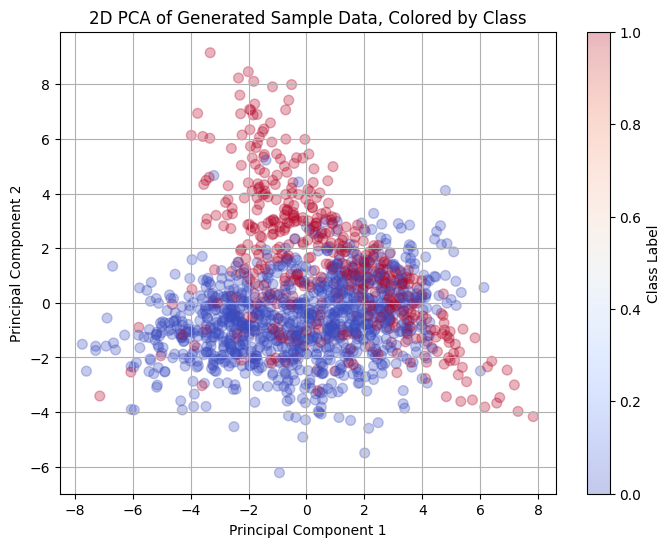

In [22]:
from sklearn.decomposition import PCA

# Reduce dimensions for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='coolwarm', s=50, alpha=0.3)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D PCA of Generated Sample Data, Colored by Class')
plt.colorbar(scatter, label='Class Label')
plt.grid(True)
plt.show()


Initializing models...
Fuzzy NN Parameters: 495
MLP Parameters: 769

Training Fuzzy Neural Network...
Epoch [0/100], Train Loss: 0.6297, Train Acc: 67.44%, Val Loss: 0.5399, Val Acc: 67.33%
Epoch [20/100], Train Loss: 0.2262, Train Acc: 93.33%, Val Loss: 0.2524, Val Acc: 94.00%
Epoch [40/100], Train Loss: 0.2038, Train Acc: 93.44%, Val Loss: 0.2591, Val Acc: 93.33%
Epoch [60/100], Train Loss: 0.1957, Train Acc: 94.11%, Val Loss: 0.2689, Val Acc: 92.67%
Epoch [80/100], Train Loss: 0.2053, Train Acc: 94.11%, Val Loss: 0.2873, Val Acc: 92.67%
Fuzzy Neural Network training completed in 6.63 seconds

Training MLP Network...
Epoch [0/100], Train Loss: 0.4355, Train Acc: 83.11%, Val Loss: 0.2965, Val Acc: 91.67%
Epoch [20/100], Train Loss: 0.2427, Train Acc: 92.00%, Val Loss: 0.2269, Val Acc: 94.00%
Epoch [40/100], Train Loss: 0.2195, Train Acc: 93.44%, Val Loss: 0.2383, Val Acc: 94.00%
Epoch [60/100], Train Loss: 0.1945, Train Acc: 94.00%, Val Loss: 0.2839, Val Acc: 94.00%
Epoch [80/100], T

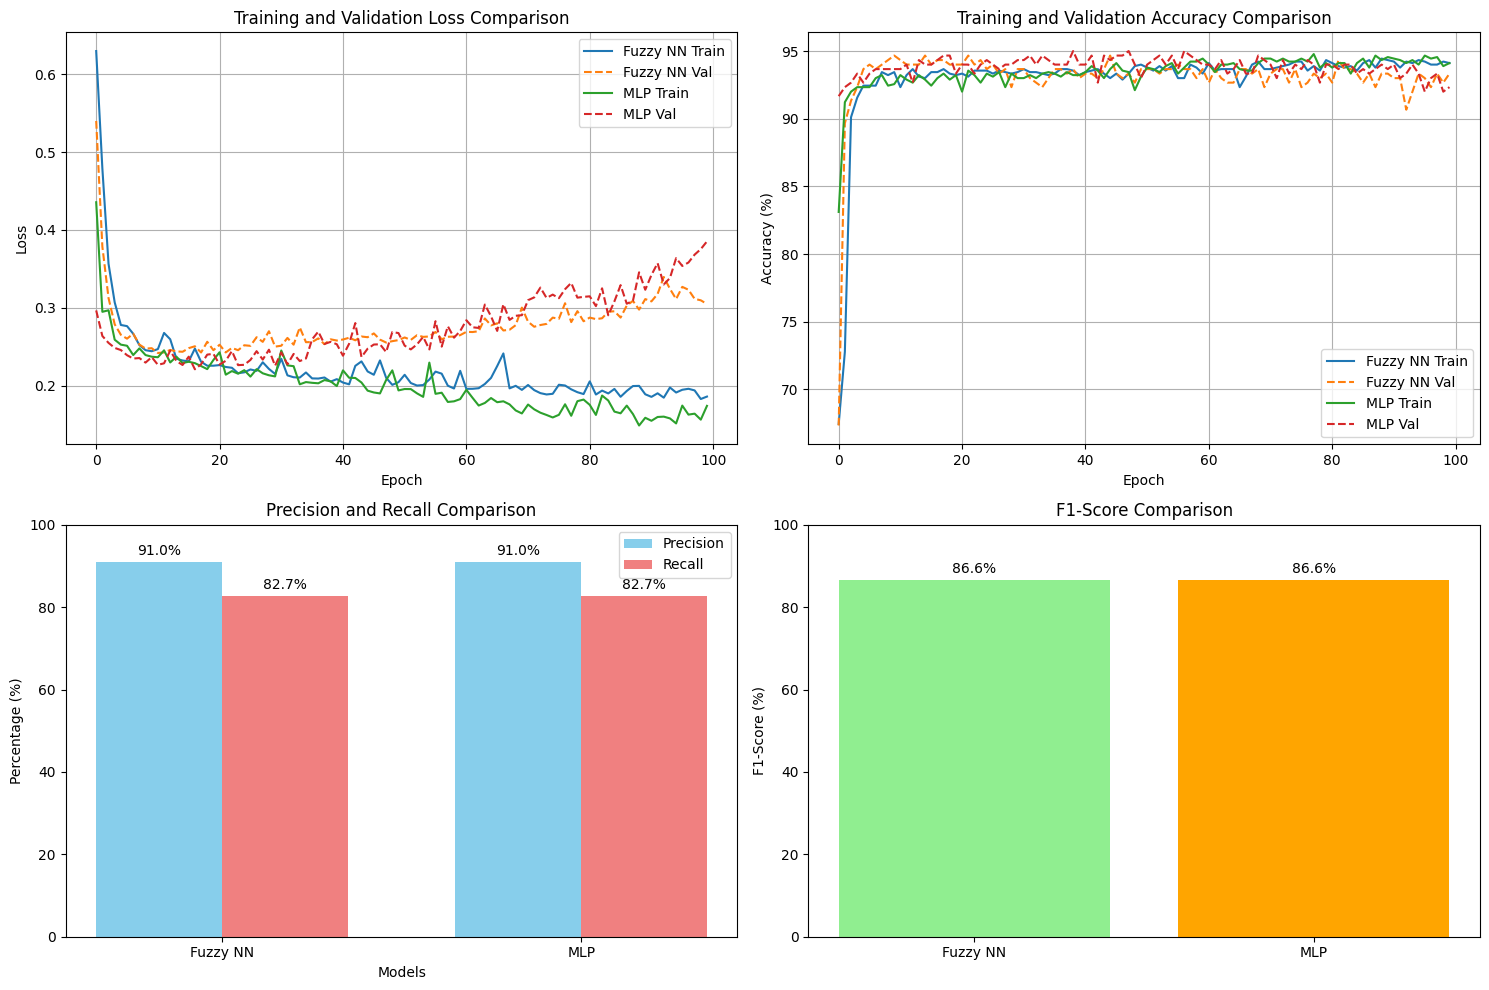

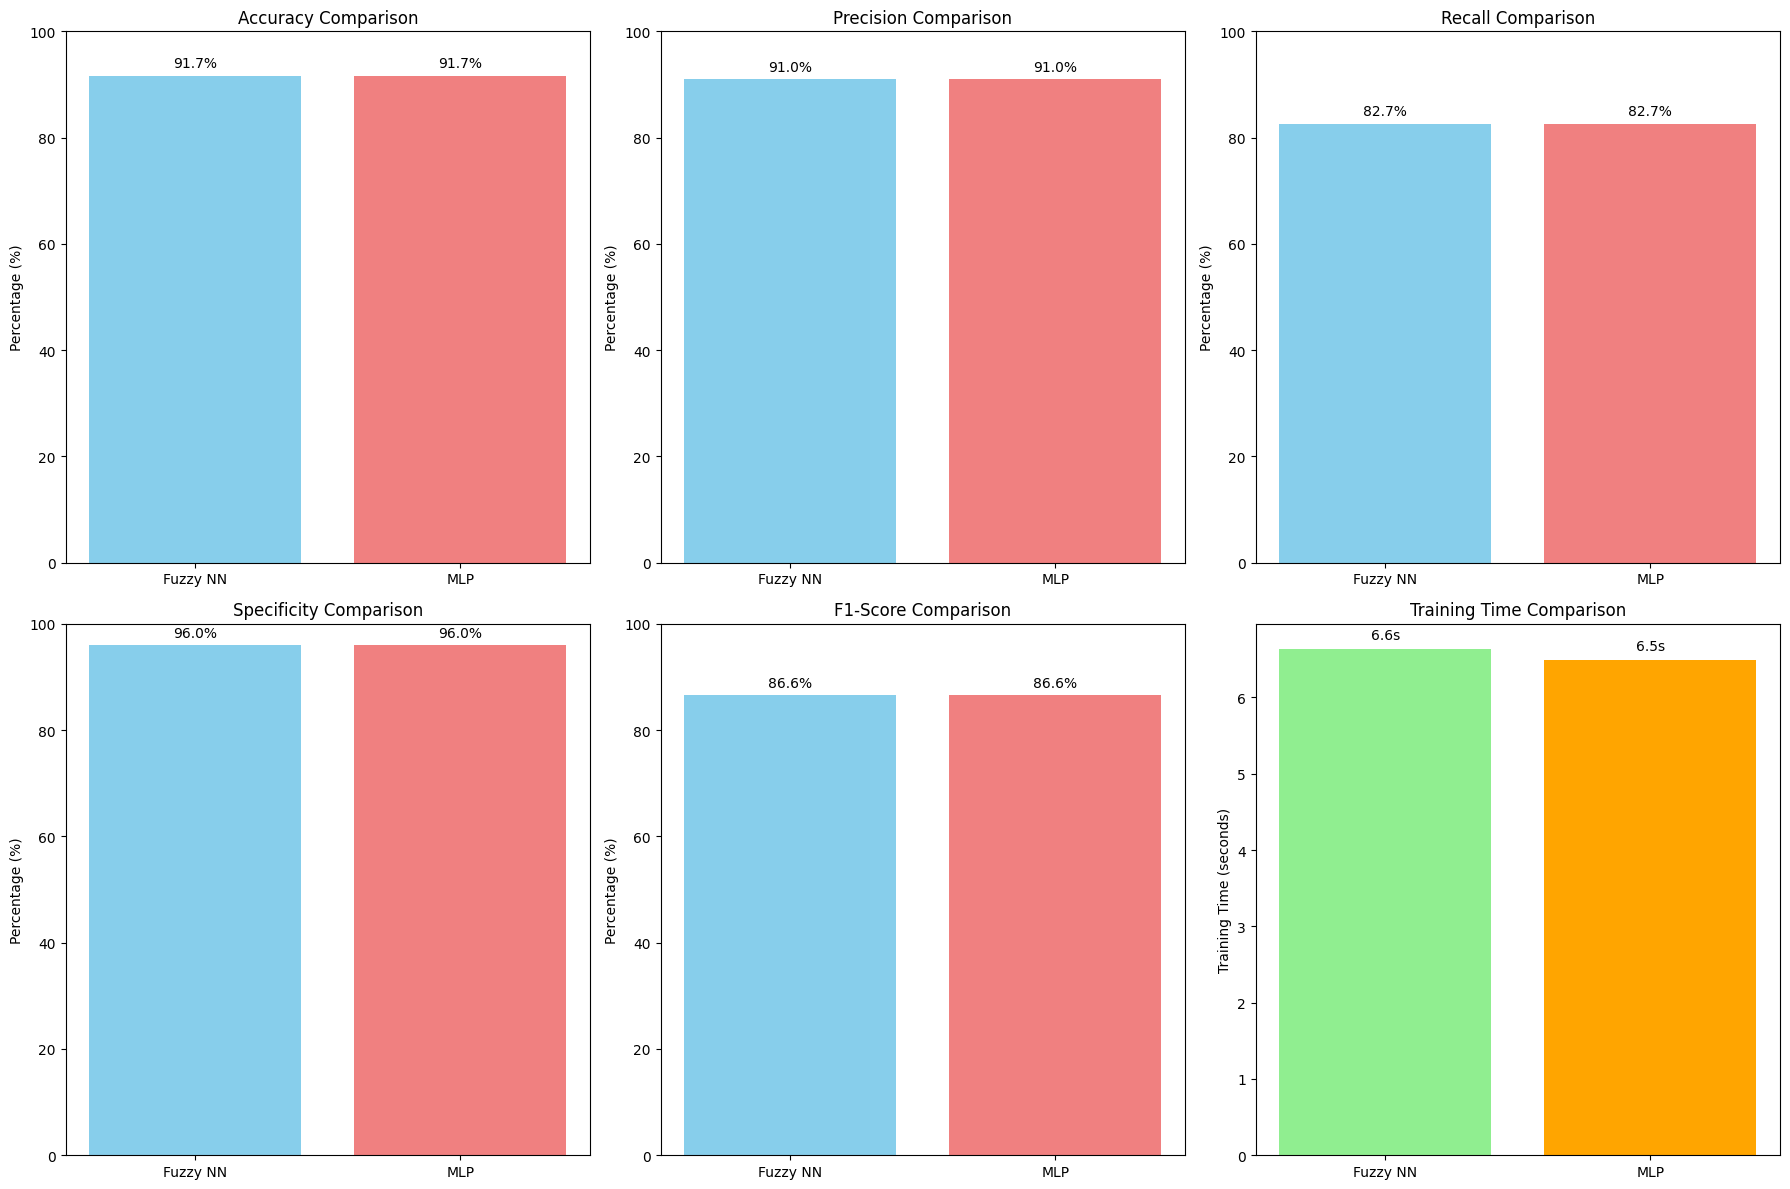

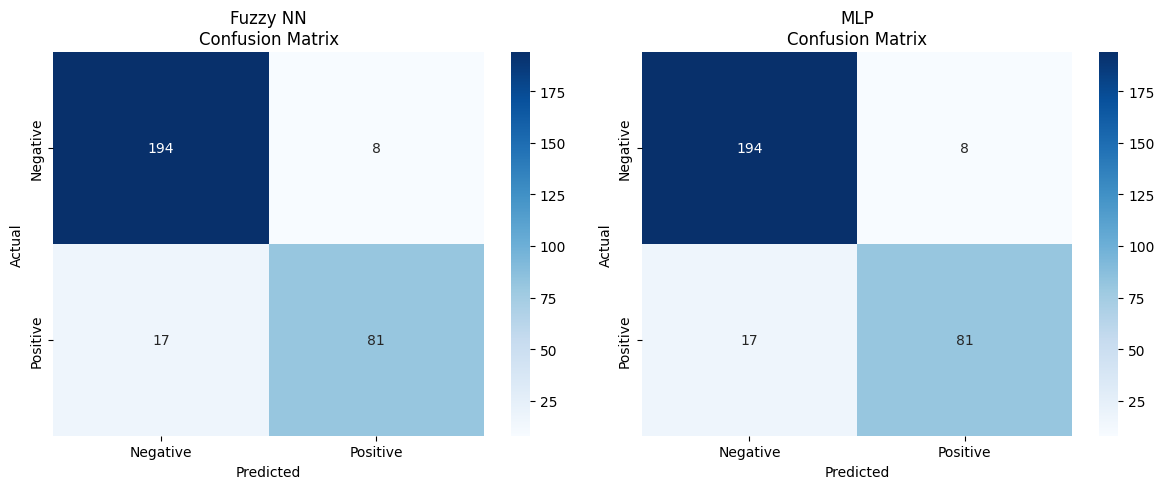


Sample Predictions Comparison:
Sample   Actual   Fuzzy Prob   MLP Prob     Fuzzy Pred   MLP Pred    
---------------------------------------------------------------------------
1        1        0.031        0.003        0            0           
2        1        0.984        0.995        1            1           
3        0        0.064        0.044        0            0           
4        0        0.010        0.086        0            0           
5        1        0.019        0.053        0            0           

SKLEARN CLASSIFICATION REPORTS

Fuzzy Neural Network:
              precision    recall  f1-score   support

     Class 0       0.92      0.96      0.94       202
     Class 1       0.91      0.83      0.87        98

    accuracy                           0.92       300
   macro avg       0.91      0.89      0.90       300
weighted avg       0.92      0.92      0.92       300


MLP Network:
              precision    recall  f1-score   support

     Class 0       0.

In [23]:



    # Initialize models
    print("\nInitializing models...")

    # Fuzzy Neural Network
    fuzzy_model = FuzzyNeuralNetwork(
        input_dim=input_dim,
        num_fuzzy_memberships=12,
        hidden_dim=25,
        output_dim=output_dim
    )

    # MLP Network
    mlp_model = MLPNetwork(
        input_dim=input_dim,
        hidden_dim1=32,
        hidden_dim2=16,
        output_dim=output_dim
    )

    print(f"Fuzzy NN Parameters: {count_parameters(fuzzy_model):,}")
    print(f"MLP Parameters: {count_parameters(mlp_model):,}")

    # Store results
    results_dict = {}

    # Train and evaluate Fuzzy Neural Network
    fuzzy_train_losses, fuzzy_val_losses, fuzzy_train_accuracies, fuzzy_val_accuracies, fuzzy_training_time = train_model(
        fuzzy_model, train_loader, val_loader, num_epochs=100, learning_rate=0.01, model_name="Fuzzy Neural Network"
    )

    # Get predictions for fuzzy model
    fuzzy_y_true, fuzzy_y_pred = get_predictions(fuzzy_model, test_loader)
    fuzzy_metrics = calculate_metrics(fuzzy_y_true, fuzzy_y_pred)
    fuzzy_metrics.update({
        'train_losses': fuzzy_train_losses,
        'val_losses': fuzzy_val_losses,
        'train_accuracies': fuzzy_train_accuracies,
        'val_accuracies': fuzzy_val_accuracies,
        'training_time': fuzzy_training_time,
        'parameters': f"{count_parameters(fuzzy_model):,}"
    })

    results_dict["Fuzzy NN"] = fuzzy_metrics

    # Train and evaluate MLP
    mlp_train_losses, mlp_val_losses, mlp_train_accuracies, mlp_val_accuracies, mlp_training_time = train_model(
        mlp_model, train_loader, val_loader, num_epochs=100, learning_rate=0.01, model_name="MLP Network"
    )

    # Get predictions for MLP model
    mlp_y_true, mlp_y_pred = get_predictions(mlp_model, test_loader)
    mlp_metrics = calculate_metrics(mlp_y_true, mlp_y_pred)
    mlp_metrics.update({
        'train_losses': mlp_train_losses,
        'val_losses': mlp_val_losses,
        'train_accuracies': mlp_train_accuracies,
        'val_accuracies': mlp_val_accuracies,
        'training_time': mlp_training_time,
        'parameters': f"{count_parameters(mlp_model):,}"
    })

    results_dict["MLP"] = mlp_metrics

    # Print detailed comparison
    print_detailed_comparison(results_dict)

    # Print confusion matrix details
    print_confusion_matrix_details(results_dict)

    # Plot all visualizations
    print("\nGenerating visualizations...")
    plot_training_curves(results_dict)
    plot_detailed_metrics(results_dict)
    plot_confusion_matrices(results_dict)

    # Show some sample predictions from both models
    print("\nSample Predictions Comparison:")
    fuzzy_model.eval()
    mlp_model.eval()

    with torch.no_grad():
        sample_x = X_test_tensor[:5]
        sample_y = y_test_tensor[:5]

        fuzzy_predictions = fuzzy_model(sample_x)
        mlp_predictions = mlp_model(sample_x)

        print(f"{'Sample':<8} {'Actual':<8} {'Fuzzy Prob':<12} {'MLP Prob':<12} {'Fuzzy Pred':<12} {'MLP Pred':<12}")
        print("-" * 75)

        for i in range(5):
            actual = sample_y[i].item()
            fuzzy_prob = fuzzy_predictions[i].item()
            mlp_prob = mlp_predictions[i].item()
            fuzzy_pred = int(fuzzy_prob > 0.5)
            mlp_pred = int(mlp_prob > 0.5)

            print(f"{i+1:<8} {actual:<8} {fuzzy_prob:<12.3f} {mlp_prob:<12.3f} "
                  f"{fuzzy_pred:<12} {mlp_pred:<12}")

    # Print sklearn classification report for additional insights
    print("\n" + "="*60)
    print("SKLEARN CLASSIFICATION REPORTS")
    print("="*60)

    print("\nFuzzy Neural Network:")
    print(classification_report(fuzzy_y_true, fuzzy_y_pred, target_names=['Class 0', 'Class 1']))

    print("\nMLP Network:")
    print(classification_report(mlp_y_true, mlp_y_pred, target_names=['Class 0', 'Class 1']))